<a href="https://colab.research.google.com/github/nkumarcc/2048-NN/blob/master/2048_rl_pytorch_02_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
!pip install selenium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from random import randint, shuffle, seed
import sys
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [ ]:
from IPython.display import clear_output

In [ ]:
!wget https://raw.githubusercontent.com/nkumarcc/2048-NN/master/c2048.py

--2023-02-25 03:42:13--  https://raw.githubusercontent.com/nkumarcc/2048-NN/master/c2048.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5949 (5.8K) [text/plain]
Saving to: ‘c2048.py.1’

c2048.py.1          100%[===================>]   5.81K  --.-KB/s    in 0s      

2023-02-25 03:42:13 (70.9 MB/s) - ‘c2048.py.1’ saved [5949/5949]



In [ ]:
from c2048 import Game, push

In [ ]:
import numpy as np

### New PyTorch NN

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
import torch
import torch.nn as nn

N_FILTERS = 512
N_FILTERS_2 = 4096
NUM_OPTIONS = 16

class PlayerNet(nn.Module):
    def __init__(self):
        super(PlayerNet, self).__init__()

        # Input size: (None, 16, 4, 4)
        # (Num samples, hot encoding of value, height, width)

        # 2D convolutional layers
        # Input size: (None, 16, 4, 4)
        self.conv_a = nn.Conv2d(in_channels=NUM_OPTIONS, out_channels=N_FILTERS, kernel_size=(2, 1), padding='valid')
        # (None, N_FILTERS, 3, 4)
        self.conv_b = nn.Conv2d(in_channels=NUM_OPTIONS, out_channels=N_FILTERS, kernel_size=(1, 2), padding='valid')
        # (None, N_FILTERS, 4, 3)

        self.conv_aa = nn.Conv2d(in_channels=N_FILTERS, out_channels=N_FILTERS_2, kernel_size=(2, 1), padding='valid')
        # (None, N_FILTERS_2, 2, 4)
        self.conv_ab = nn.Conv2d(in_channels=N_FILTERS, out_channels=N_FILTERS_2, kernel_size=(1, 2), padding='valid')
        # (None, N_FILTERS_2, 3, 3)

        self.conv_ba = nn.Conv2d(in_channels=N_FILTERS, out_channels=N_FILTERS_2, kernel_size=(2, 1), padding='valid')
        # (None, N_FILTERS_2, 3, 3)
        self.conv_bb = nn.Conv2d(in_channels=N_FILTERS, out_channels=N_FILTERS_2, kernel_size=(1, 2), padding='valid')
        # (None, N_FILTERS_2, 4, 2)

        # flatten the output of each convolutional layer
        # Output sizes will be:
        # - (Num Samples, N_FILTERS * 3 * 4) x 2
        # - (Num Samples, N_FILTERS_2 * 3 * 3) x 2
        # - (Num Samples, N_FILTERS_2 * 2 * 4) x 2
        self.flatten = nn.Flatten()

        # concatenation layer
        # Not sure this is the right axis
        # Output size will be:
        # (Num Samples, N_FILTERS * 24 + N_FILTERS_2 * 34)

        # dense layer
        self.fc = nn.Linear(
            in_features=N_FILTERS * 24 + N_FILTERS_2 * 34,
            out_features=1
        )
        self.fc.activation = nn.Identity()

        # Error is scaled MSE
        self.loss_fn = nn.MSELoss()
        self.loss_scale = torch.tensor([0.5]).to(device)

        # Adam optimizer
        self.optimizer = torch.optim.Adam(self.parameters())
        # , betas=(0.5, 0.999)

    def forward(self, x):
        # pdb.set_trace()
        conv_a = self.conv_a(x)
        conv_b = self.conv_b(x)

        conv_aa = self.conv_aa(conv_a)
        conv_ab = self.conv_ab(conv_a)

        conv_bb = self.conv_bb(conv_b)
        conv_ba = self.conv_ba(conv_b)

        # flatten the output of the convolutional layer
        flattened_convs = [
            self.flatten(z) for z in [conv_a, conv_b, conv_aa, conv_ab, conv_bb, conv_ba]
        ]

        concatenated = torch.cat(flattened_convs, axis=1)
        final_out = self.fc(concatenated)

        return final_out

    def train_step(self, x, y):
        # Forward pass
        y_pred = self.forward(x)
        # Using prediction from the forward pass
        # being used to drive the game

        # Compute loss
        loss = self.loss_fn(y_pred, y)
        loss = loss * self.loss_scale

        # Backward pass
        loss.backward()

        # Update parameters
        self.optimizer.step()

        # Reset gradients
        self.optimizer.zero_grad()

        return loss

In [ ]:
player_net = PlayerNet().to(device)

### Driver Functions (copied from original notebook)

In [ ]:
import numpy as np
from random import randint

table ={2**i:i for i in range(1,16)}
table[0]=0
def make_input(grid):
    g0 = grid
    r = np.zeros(shape=(16, 4, 4), dtype=float)
    for i in range(4):
        for j in range(4):
            v = g0[i, j]
            r[table[v],i, j]=1
    return r

In [ ]:
from random import random, randint

def get_grid(driver):
    grid = np.zeros(shape=(4,4), dtype='uint16')
    for x in driver.find_elements(By.CLASS_NAME, 'tile'):
        cl = x.get_attribute('class').split()
        for t in cl:
            if t.startswith('tile-position-'):
                pos = int(t[14])-1, int(t[16])-1
            elif t.startswith('tile-') and t[5].isdigit():
                v = int(t[5:])
        grid[pos[1], pos[0]] = v
    return grid

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

In [ ]:
import math
import time
from collections import defaultdict
from selenium.webdriver.common.by import By
  
def Vchange(grid, v):
    g0 = grid
    g1 = torch.flip(g0, [1])
    g2 = torch.flip(g0, [2])
    g3 = torch.flip(g2, [1])
    r0 = grid.swapaxes(1,2)
    r1 = torch.flip(r0, [1])
    r2 = torch.flip(r0, [2])
    r3 = torch.flip(r2, [1])

    try:
        x_train = torch.stack([g0,g1,g2,g3,r0,r1,r2,r3], dim=0)
        # pdb.set_trace()
        y_train = torch.stack([v]*8, dim=0)
        # y_pred = torch.cat([prediction]*8, dim=0)
    except:
        print('Error and great spot for a breakpoint!')
        return
    return player_net.train_step(x_train, y_train)

arrow=[Keys.ARROW_LEFT, Keys.ARROW_UP, Keys.ARROW_RIGHT, Keys.ARROW_DOWN]
def gen_sample_and_learn(driver, use_webdriver=False):
    game_len = 0
    game_score = 0
    last_grid = None
    grid_array = None
    loss_array = []
    simulated_game = Game()

    body = driver.find_element(By.TAG_NAME, 'body') if use_webdriver else None
    keep_playing =False

    while True:

        if use_webdriver:
            try:
                grid_array = get_grid(driver)
            except:
                grid_array = None

            try:
                game_message = driver.find_element(By.CLASS_NAME, 'game-message')
                retry_button = driver.find_element(By.CLASS_NAME, 'retry-button')
                if game_message.value_of_css_property('display') != 'none' and \
                    retry_button.value_of_css_property('display') != 'none':
                    break
            except:
                pass
        else:
            grid_array = simulated_game.grid

        board_list = []
        # pdb.set_trace()
        if grid_array is not None:
            if use_webdriver and not keep_playing and grid_array.max()==2048:
                driver.find_element(By.CLASS_NAME, 'keep-playing-button').click()
                keep_playing = True
                time.sleep(1)
            for m in range(4):
                g = grid_array.copy()
                s = push(g, m%4)
                if s >= 0:
                    board_list.append( (g, m, s) )
        if board_list:
            boards = torch.tensor(
                np.array(
                    [make_input(g) for g,m,s in board_list], 
                    dtype=float
                ),
                dtype=torch.float32,
            ).to(device)

            player_net.eval()
            with torch.no_grad():
              p = player_net(boards)
            player_net.train()

            game_len+=1
            best_move = -1
            best_v = None
            best_prediction = None
            for i, (g,m,s) in enumerate(board_list):
                v = 2*s + p[i]
                if best_v is None or v > best_v:
                    best_v = v
                    best_move = m
                    best_score = 2*s
                    best_prediction = p[i]
                    best_grid = boards[i]
            if use_webdriver:
                body.send_keys(arrow[best_move])
            else:
                # simulated_game.display()
                simulated_game.move(best_move)
            # print(f'Best prediction: {best_prediction}')
            game_score += best_score
        else:
            best_v = torch.Tensor([0]).to(device)
            best_grid = None
        if last_grid is not None:
            loss = Vchange(last_grid, best_v)
            # print(f'Loss: {loss}')
            loss_array.append(loss)
        last_grid = best_grid
        if not board_list:
            break
        plt.pause(0.05)
    
    avg_loss = torch.mean(torch.stack(loss_array))
    print(f'Average Loss, {avg_loss}')
    return game_len, grid_array.max(), game_score

In [ ]:
!apt-get update
!apt install firefox-geckodriver

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:14 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InR

In [ ]:
import pdb; 

<ipython-input-65-6e60f1966be6>:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(options=options, executable_path='/usr/bin/geckodriver')


Best prediction: tensor([2006.0935], device='cuda:0')


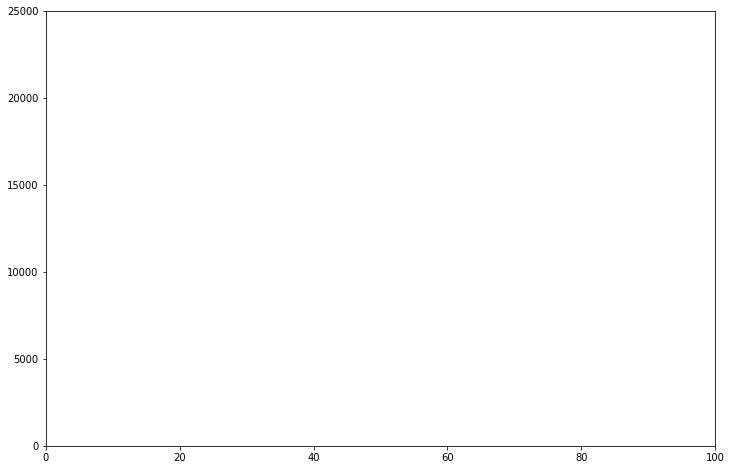

Best prediction: tensor([1963.5095], device='cuda:0')
Loss: tensor([893.1185], device='cuda:0', grad_fn=<MulBackward0>)
Best prediction: tensor([1991.9674], device='cuda:0')
Loss: tensor([70.2024], device='cuda:0', grad_fn=<MulBackward0>)
Best prediction: tensor([2067.4463], device='cuda:0')
Loss: tensor([1162.4193], device='cuda:0', grad_fn=<MulBackward0>)
Best prediction: tensor([2049.7412], device='cuda:0')
Loss: tensor([1815.9032], device='cuda:0', grad_fn=<MulBackward0>)
Best prediction: tensor([2060.6489], device='cuda:0')
Loss: tensor([28.3624], device='cuda:0', grad_fn=<MulBackward0>)
Best prediction: tensor([2001.5448], device='cuda:0')
Loss: tensor([2978.5776], device='cuda:0', grad_fn=<MulBackward0>)
Best prediction: tensor([1987.0997], device='cuda:0')
Loss: tensor([53.1040], device='cuda:0', grad_fn=<MulBackward0>)
Best prediction: tensor([1981.6615], device='cuda:0')
Loss: tensor([10.6840], device='cuda:0', grad_fn=<MulBackward0>)
Best prediction: tensor([1980.6403], devi

KeyboardInterrupt: ignored

In [ ]:
results = []
# driver = webdriver.Firefox(executable_path='./geckodriver')
options = webdriver.FirefoxOptions()
options.add_argument('--headless')  # to run the browser in headless mode
options.binary_location = '/usr/bin/firefox'

driver = webdriver.Firefox(options=options, executable_path='/usr/bin/geckodriver')
# driver = None
graph = plt.plot([], [], 'b')[0]
dots256 = plt.plot([],[], 'ro')[0]
dots512 = plt.plot([],[], 'yo')[0]
dots1024 = plt.plot([],[], 'go')[0]
plt.xlim((0,100))
plt.ylim((0,25000))
for j in range(200):
    # driver.get("https://gabrielecirulli.github.io/2048/")
    # pdb.set_trace()
    time.sleep(2)
    result = gen_sample_and_learn(driver)
    print(j, result)
    results.append(result)
    if (j % 25) == 0 and j != 0:
      graph.set_data(np.arange(len(results)), np.array(results)[:, 2])
      dots_data =[[],[],[]]
      for i, d in enumerate(results):
          c = 0 if d[1]<=256 else (1 if d[1]==512 else 2)
          dots_data[c].append([i, d[2]])
      dots_graph = [dots256, dots512, dots1024]
      for i in range(3):
          if dots_data[i]:
              xy = np.array(dots_data[i])
              dots_graph[i].set_data(xy[:, 0], xy[:,1])
      plt.title("Game #%d"%j, fontsize=64)
      plt.draw()
      plt.pause(3)
    if result[1] >= 2048:
        break

Both of these are with simulator. Using Selenium, we're looking at 1 min 30s per game

With CPU:
- 5m - 3 games

With GPU:
- 30s per game, if even